In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
import numpy as np
import tensorflow as tf

In [22]:
IMAGE_SIZE =128
BATCH_SIZE = 32

dataset = image_dataset_from_directory(
    "PlantVillage",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [30]:
total_batches = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * total_batches)
val_size = int(0.1 * total_batches)

In [31]:
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

In [32]:
feature_extractor = EfficientNetB0(include_top=False, pooling='avg', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
feature_extractor.trainable = False

In [33]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [34]:
num_classes = len(class_names)
num_classes

3

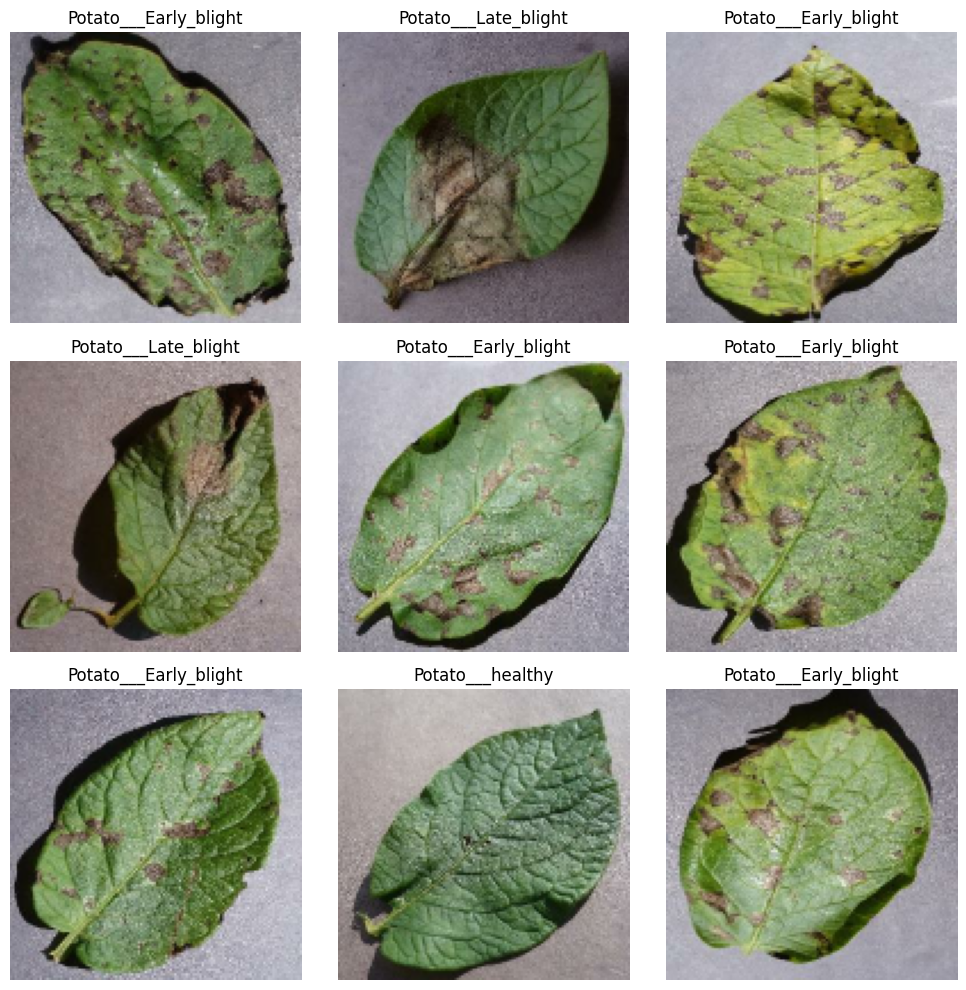

In [35]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
X = []
y = []
for batch_images, batch_labels in dataset:
    rescaled_images = batch_images / 255.0
    flat_images = rescaled_images.numpy().reshape(rescaled_images.shape[0], -1)
    X.extend(flat_images)
    y.extend(batch_labels.numpy())

X = np.array(X)
y = np.array(y)


In [36]:
def extract_features(dataset):
    features = []
    labels = []
    for batch_images, batch_labels in dataset:
        batch_images = tf.image.resize(batch_images, (IMAGE_SIZE, IMAGE_SIZE))
        batch_images = batch_images / 255.0
        batch_features = feature_extractor.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels.numpy())
    return np.vstack(features), np.concatenate(labels)

In [37]:
X_train, y_train = extract_features(train_ds)
X_val, y_val = extract_features(val_ds)
X_test, y_test = extract_features(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [41]:
model = SVC(kernel='rbf', probability=True)
model.fit(X_train_pca, y_train)

SVC(probability=True)

In [42]:
train_preds = model.predict(X_train_pca)
val_preds = model.predict(X_val_pca)
test_preds = model.predict(X_test_pca)

In [45]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_val, val_preds)
test_acc = accuracy_score(y_test, test_preds)
print("Train Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)
print("Test Accuracy:", test_acc)

Train Accuracy: 0.9212962962962963
Validation Accuracy: 0.890625
Test Accuracy: 0.9008620689655172


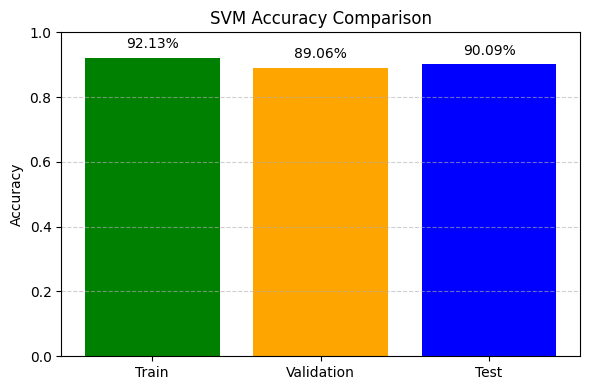

In [48]:
# Accuracy bar plot
plt.figure(figsize=(6, 4))
plt.bar(['Train', 'Validation', 'Test'], [train_acc, val_acc, test_acc], color=['green', 'orange', 'blue'])
plt.ylim(0, 1)
plt.title('SVM Accuracy Comparison')
plt.ylabel('Accuracy')
for i, acc in enumerate([train_acc, val_acc, test_acc]):
    plt.text(i, acc + 0.02, f"{acc:.2%}", ha='center', va='bottom')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [49]:
val_report = classification_report(y_val, val_preds, target_names=class_names, output_dict=True)
test_report = classification_report(y_test, test_preds, target_names=class_names, output_dict=True)

val_report_df = pd.DataFrame(val_report).transpose()[['precision', 'recall', 'f1-score', 'support']]
test_report_df = pd.DataFrame(test_report).transpose()[['precision', 'recall', 'f1-score', 'support']]

print("\nValidation Classification Report:")
display(val_report_df.style.set_caption("Validation Report").set_table_styles([{'selector': 'caption','props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]}]))

print("\nTest Classification Report:")
display(test_report_df.style.set_caption("Test Report").set_table_styles([{'selector': 'caption','props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]}]))


Validation Classification Report:


,precision,recall,f1-score,support
Potato___Early_blight,0.949495,0.940000,0.944724,100.000000
Potato___Late_blight,0.824176,0.961538,0.887574,78.000000
Potato___healthy,1.000000,0.142857,0.250000,14.000000
accuracy,0.890625,0.890625,0.890625,0.890625
macro avg,0.924557,0.681465,0.694099,192.000000
weighted avg,0.902267,0.890625,0.870850,192.000000



Test Classification Report:


,precision,recall,f1-score,support
Potato___Early_blight,0.923810,0.932692,0.928230,104.000000
Potato___Late_blight,0.880000,0.956522,0.916667,115.000000
Potato___healthy,1.000000,0.153846,0.266667,13.000000
accuracy,0.900862,0.900862,0.900862,0.900862
macro avg,0.934603,0.681020,0.703854,232.000000
weighted avg,0.906363,0.900862,0.885428,232.000000


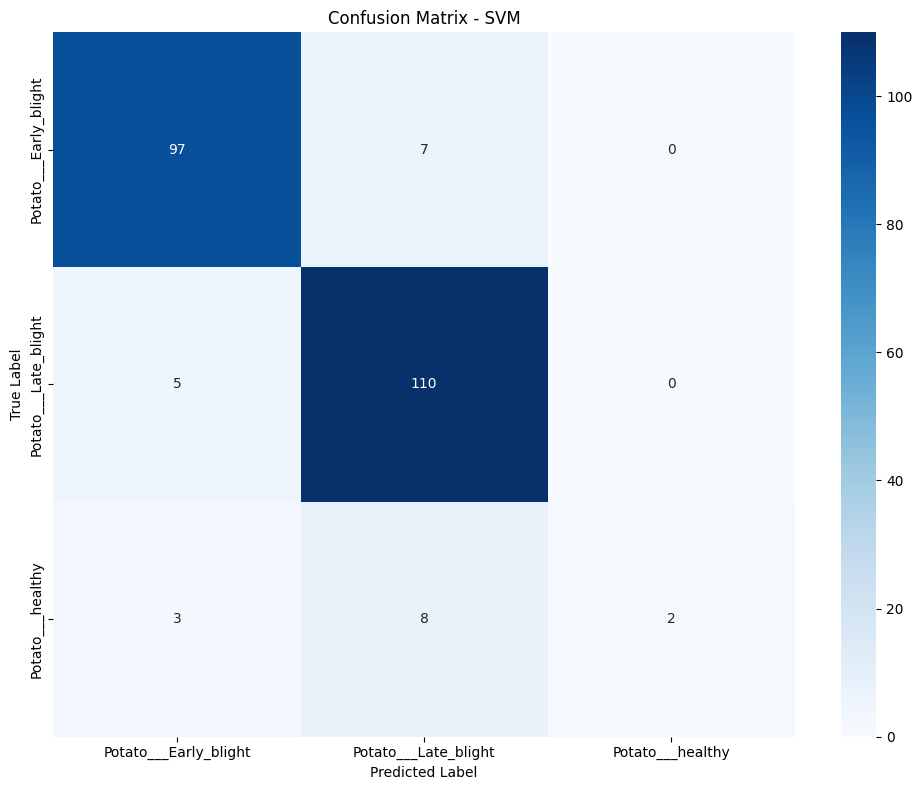

In [50]:
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [57]:
def predict_with_svm(model, image_tensor, scaler, pca, class_names):
    # Step 1: Resize and normalize
    img_resized = tf.image.resize(image_tensor, (IMAGE_SIZE, IMAGE_SIZE))
    img_resized = tf.expand_dims(img_resized, axis=0) / 255.0  # Shape: (1, H, W, C)

    # Step 2: Extract CNN features
    cnn_features = feature_extractor.predict(img_resized)

    # Step 3: Scale + PCA
    cnn_scaled = scaler.transform(cnn_features)
    cnn_pca = pca.transform(cnn_scaled)

    # Step 4: Predict
    probabilities = model.predict_proba(cnn_pca)[0]
    predicted_index = np.argmax(probabilities)
    confidence = round(probabilities[predicted_index] * 100, 2)
    predicted_class = class_names[predicted_index]
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


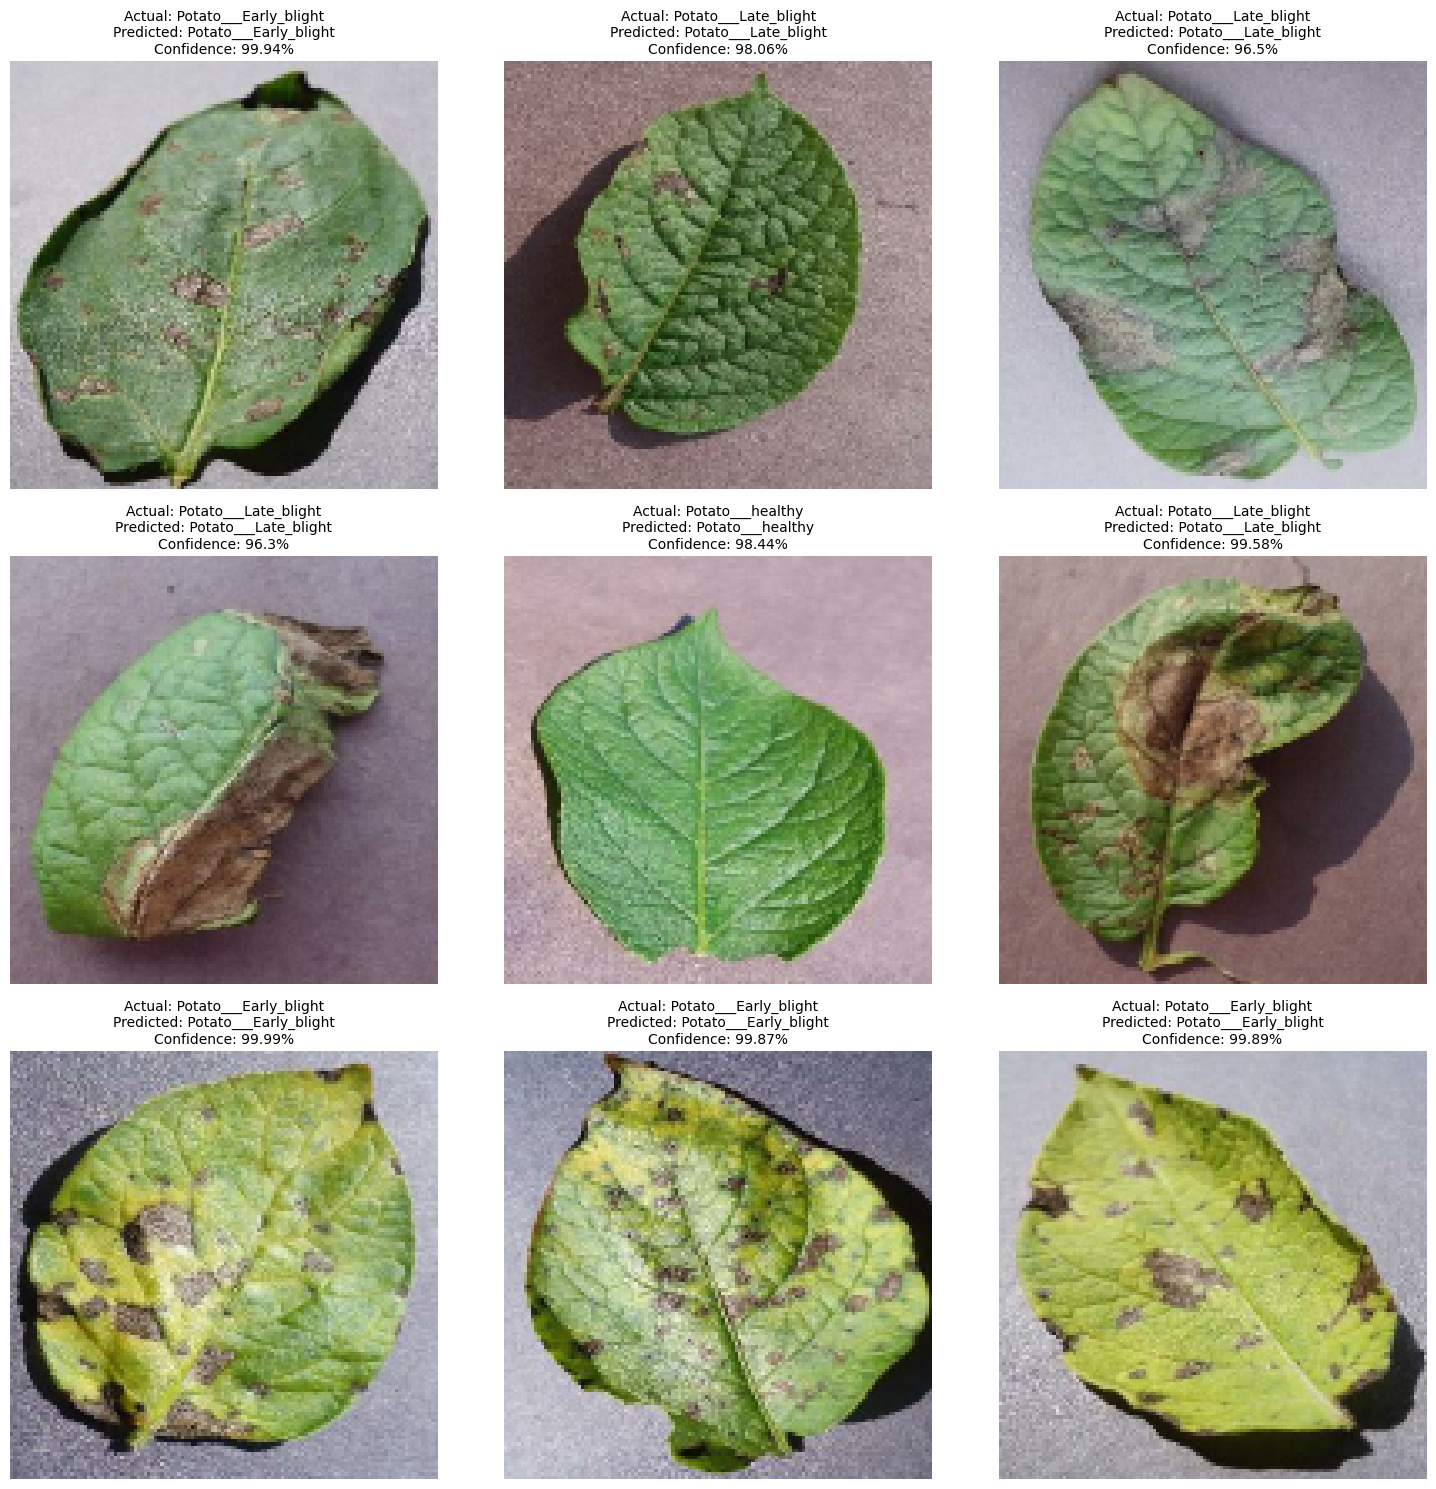

In [58]:
plt.figure(figsize=(15, 15))

for images, labels in dataset.take(1):  # Use 'dataset' or your original test_ds if defined
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # Predict using SVM
        predicted_class, confidence = predict_with_svm(model, images[i], scaler, pca, class_names)
        actual_class = class_names[labels[i].numpy()]

        # Plot
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%", fontsize=10)
        plt.axis("off")

plt.tight_layout()
plt.show()

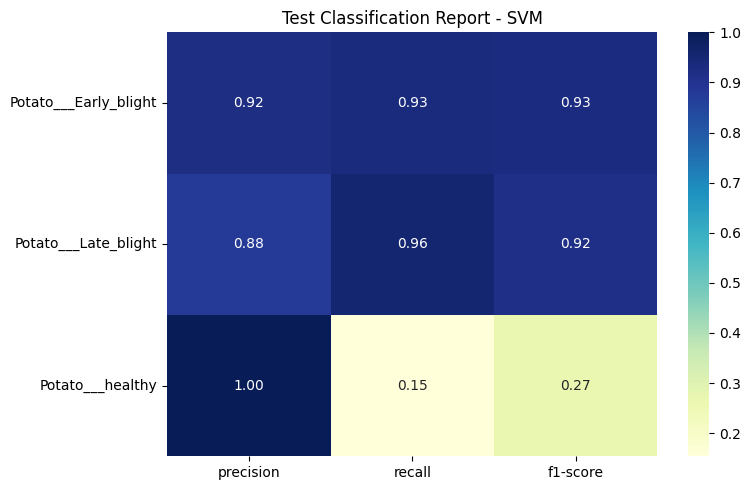

In [59]:
# Convert test classification report to DataFrame
report_df = pd.DataFrame(test_report).transpose()
report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

# Heatmap of precision, recall, f1-score
plt.figure(figsize=(8, 5))
sns.heatmap(report_df[['precision', 'recall', 'f1-score']], annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Test Classification Report - SVM")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [62]:
import joblib

joblib.dump(model, "../models/svm_model.pkl")
joblib.dump(scaler, "../models/svm_scaler.pkl")
joblib.dump(pca, "../models/svm_pca.pkl")

['../models/svm_pca.pkl']